In [32]:
# This data analysis focuses on a collection of current sales and offers from Well.ca, 
# an online health and beauty store. The dataset was created using web mining techniques, 
# which involved scraping the Well.ca website to gather information about the products in the sale category. 
# The dataset includes the product name, original price, and new price for each item.
# It is important to note that not all products in the sale category have discounts. 
# Therefore, the analysis will involve performing additional calculations and sorting to determine 
# the discount percentage from highest to lowest for each item in the dataset. This will allow us to explore 
# the distribution of discounts across various ranges and identify the most common discount range offered by the store.

# The goal of this analysis is to gain insights into the pricing strategies and promotional offers of Well.ca. 
# By examining the prevalence of different discount ranges, we can understand which discount ranges are 
# most frequently proposed by the store. This information can be valuable for both the store and customers 
# in making informed purchasing decisions and understanding market trends in the health and beauty industry.

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup

In [99]:
url = 'https://well.ca/categories/Sales-and-Specials.html'

In [4]:
# Send a GET request to the webpage
response = requests.get(url)

# Parse the HTML content using BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Find the div element with class='sales_container'
sales_div = soup.find('div', class_='sales_container')

# Find all the <a> tags within the sales_div and extract the links
links = sales_div.find_all('a')

# Create an empty list to store dictionaries of scraped data
data_list = []

# Loop through each link
for link in links:
    # Get the URL from the link's href attribute
    link_url = link['href']

    # Send a GET request to the link URL
    link_response = requests.get(link_url)

    # Parse the HTML content of the link URL
    link_soup = BeautifulSoup(link_response.content, 'html.parser')

    # Find the div element with id='categories_content'
    categories_div = link_soup.find('div', id='categories_content')

    # Check if categories_div is not None
    if categories_div:
        # Find all the div elements with class='product-item' within categories_div
        product_items = categories_div.find_all('div', class_='product-item')

        # Process each product-item div and extract relevant information
        for item in product_items:
            top_text = item.find('div', class_='product_grid_info_top_text_container').text
            price_container = item.find('div', class_='product_grid_price')

            if not price_container:
                continue
                
            original_price = price_container.find('span', class_='product_grid_original_price')
            new_price = price_container.find('span', class_='product_grid_new_price')

            if new_price:
                original_price_text = original_price.text.strip()
                new_price_text = new_price.text.strip()

                # Check if the original price is the same as the new price
                if original_price_text == new_price_text:
                    discount_percent = 0
                else:
                    # Check if the original price is a range
                    if '-' in original_price_text:
                        # Extract the minimum and maximum prices from the range and calculate the average
                        original_price_range = original_price_text.split('-')
                        original_price_min = float(original_price_range[0].replace('$', '').strip())
                        original_price_max = float(original_price_range[1].replace('$', '').strip())
                        original_price_value = (original_price_min + original_price_max) / 2
                    else:
                        original_price_value = float(original_price_text.replace('$', ''))

                    # Check if the new price is a range
                    if '-' in new_price_text:
                        # Extract the minimum and maximum prices from the range and calculate the average
                        new_price_range = new_price_text.split('-')
                        new_price_min = float(new_price_range[0].replace('$', '').strip())
                        new_price_max = float(new_price_range[1].replace('$', '').strip())
                        new_price_value = (new_price_min + new_price_max) / 2
                    else:
                        new_price_value = float(new_price_text.replace('$', ''))

                    # Calculate the discount percentage
                    discount_percent = (original_price_value - new_price_value) / original_price_value * 100
                    discount_percent = round(discount_percent, 2)

            else:
                price_text = price_container.text.strip()
                original_price_text = price_text
                new_price_text = price_text
                discount_percent = 0

            # Append the extracted data as a dictionary to the data_list
            data_list.append({'Product Item': top_text,
                              'Original Price': original_price_text,
                              'New Price': new_price_text,
                              'Discount Percent': discount_percent})

# Create a DataFrame from the data_list
data = pd.DataFrame(data_list)

# Sort the DataFrame in descending order based on 'Discount Percent'
data.sort_values(by='Discount Percent', ascending=False, inplace=True)

# Reset the index of the DataFrame
data.reset_index(drop=True, inplace=True)

# Print the resulting DataFrame
print(data)


                                           Product Item Original Price  \
0                Two Bears Frothed Matcha Tea Oat Latte          $4.29   
1                           C2O Coconut Water with Pulp          $2.99   
2                         Happy 3-Layer Face Mask Black         $26.99   
3                          Happy 3-Layer Face Mask Navy         $26.99   
4                      Happy 3-Layer Face Mask Charcoal         $26.99   
...                                                 ...            ...   
1245                   Clinique Facial Soap Refill Mild         $24.00   
1246  Clinique SPF 30 Mineral Sunscreen Lotion For Body         $48.00   
1247  Clinique Superdefense City Block Daily Energy ...         $41.00   
1248      Clinique High Impact Waterproof Mascara Black         $30.00   
1249           Clinique Take The Day Off Makeup Remover         $31.00   

     New Price  Discount Percent  
0        $0.50             88.34  
1        $0.50             83.28  
2     

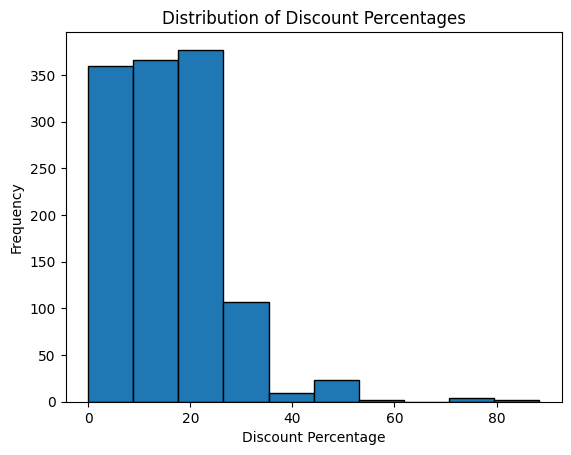

In [8]:
# Distribution of Discount Percentages histogram chart

# Create a histogram of the discount percentages
plt.hist(data['Discount Percent'].dropna(), bins=10, edgecolor='black')

# Set the labels for the x-axis and y-axis
plt.xlabel('Discount Percentage')
plt.ylabel('Frequency')

# Set the title of the plot
plt.title('Distribution of Discount Percentages')

# Display the plot
plt.show()

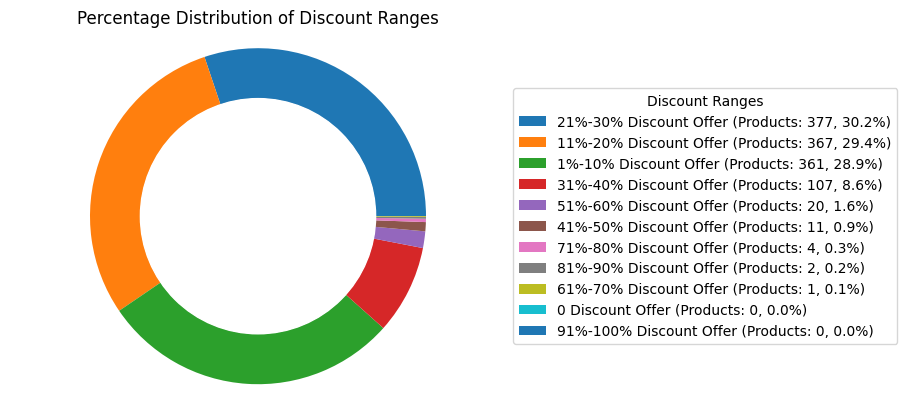

In [102]:
# Percentage Distribution of Discount Ranges donut plot

# Define the discount percentage ranges
ranges = ['0', '1%-10%', '11%-20%', '21%-30%', '31%-40%', '41%-50%',
          '51%-60%', '61%-70%', '71%-80%', '81%-90%', '91%-100%']

# Group the discount percentages into the defined ranges
grouped_discounts = data['Discount Percent'].groupby(
    pd.cut(data['Discount Percent'], bins=[-0.1, 0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], right=False)
).count()

# Get the counts for each range
counts = grouped_discounts.values

# Calculate the percentages
percentages = counts / sum(counts) * 100

# Sort the ranges and percentages based on the percentages in descending order
sorted_data = sorted(zip(ranges, counts, percentages), key=lambda x: x[2], reverse=True)
sorted_ranges, sorted_counts, sorted_percentages = zip(*sorted_data)

# Create the donut chart
wedges, _, autotexts = plt.pie(sorted_counts, autopct='', wedgeprops={'width': 0.3})

# Add a circle at the center to create the donut hole
circle = plt.Circle((0, 0), 0.7, color='white')
plt.gca().add_artist(circle)

# Set the aspect ratio to be equal
plt.axis('equal')

# Create the legend labels with Discount Percent
legend_labels = [f'{range_} Discount Offer (Products: {count}, {percent:.1f}%)' for range_, count, percent in sorted_data]

# Create the legend
legend = plt.legend(wedges, legend_labels, title="Discount Ranges", loc="center left", bbox_to_anchor=(1, 0.5))


# Set the title of the plot
plt.title('Percentage Distribution of Discount Ranges')

# Display the plot
plt.show()

In [ ]:
# Analytical Conclusion:

# The charts above represents the percentage distribution of discount ranges for a dataset of 
# beauty and health products promoted on well.ca web site. 

# Here are the key insights:

# - The discount range of 21%-30% comprises the largest portion, accounting for 30.2% of the products. 
# This indicates that there is a significant number of products with discounts in this range.

# - Following closely is the discount range of 11%-20% and 1%-10%, representing 29.4% and 28.9% accordinly of the products. 
# This suggests that there is a substantial presence of products with discounts in this range.

# This information can tell us that discounts in the range of 1%-30% may be the most frequent in this store.
# This can help the buyer make a purchasing decision or even follow a buying strategy.

# - From the data we also see that there are few products that propose 70%-90% of discount. 
# This information could be helpful to understand what types of products store ready to sell with the highest discount
# and why.

# Overall, the analysis reveals a varied distribution of discounts, with a significant number of products 
# falling within the 11%-30% range. Additionally, a substantial portion of products has discounts 
# ranging from 1%-10%. This information can be valuable for both the store and customers. 
# It enables the store to make data-driven decisions related to pricing, promotions, and marketing strategies, 
# while customers can benefit from informed purchasing decisions, budget planning, and an optimized shopping strategy.
